https://www.analyticsvidhya.com/blog/2018/05/improve-model-performance-cross-validation-in-python-r/

http://www.science.smith.edu/~jcrouser/SDS293/labs/lab7-py.html

https://machinelearningmastery.com/k-fold-cross-validation/

# Logistic Regression with Python

## Import Libraries
Let's import some libraries to get started!

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## The Data

Let's start by reading in the Churn_modeling.csv file into a pandas dataframe.

In [40]:
Churn = pd.read_csv('Churn_Modelling.csv')

In [41]:
Churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [42]:
Churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [43]:
Gender = pd.get_dummies(Churn['Gender'],drop_first=True)
Geo = pd.get_dummies(Churn['Geography'],drop_first=True)

In [44]:
Geo.head()

,Germany,Spain
0,0,0
1,0,1
2,0,0
3,0,0
4,0,1


In [45]:
Churn.drop(['Gender','Geography'],axis=1,inplace=True)

In [46]:
Churn = pd.concat([Churn,Gender,Geo],axis=1)

In [47]:
Churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Male,Germany,Spain
0,1,15634602,Hargrave,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,Hill,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,3,15619304,Onio,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,Boni,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,Mitchell,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1


## Data Cleaning

In [48]:
to_drop=['RowNumber','CustomerId','Surname']
Churn=Churn.drop(to_drop,axis=1)
Churn.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Male,Germany,Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1


# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## K-fold Cross Validation 
Below are the steps for it:

1. Randomly split your entire dataset into k”folds”
2. For each k-fold in your dataset, build your model on k – 1 folds of the dataset. Then, test the model to check the effectiveness for kth fold
3. Record the error you see on each of the predictions
4. Repeat this until each of the k-folds has served as the test set
5. The average of your k recorded errors is called the cross-validation error and will serve as your performance metric for the model

#### Split the data

In [49]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

In [50]:
df = Churn.copy()

In [51]:
X = df.drop('Exited',axis=1)
y = df['Exited']

In [55]:
def Logistic_Kfold(X, y ,k , thrshld=0.5):
    '''
    df = Original data Data frame 
    X =Data Frame of Explanatory varibales
    y =Data Frame of Target variable
    f =number of folds
    threshold = default 0.5
    '''
    kf = KFold(n_splits=k,random_state=1,shuffle=True)
    for train,test in kf.split(df):
        X_train, X_test = X.iloc[train], X.iloc[test]
        y_train, y_test = y.iloc[train], y.iloc[test]
        logmodel = LogisticRegression()
        logmodel.fit(X_train,y_train)
        logical = logmodel.predict_proba(X_test)[:,1]>thrshld
        pred = [0]*np.size(logical)
        for i in np.arange(0,np.size(logical)):
            if logical[i]==True:
                pred[i]=1
        cm = confusion_matrix(y_test,pred)
        print('\n Confusion Matrix: \n',cm)
        cr = classification_report(y_test,pred)
        print('\n classification report: \n ',cr)
        logit_roc_auc = roc_auc_score(y_test,pred)
        print('\n ROC Score: \n',logit_roc_auc)
        print('--'*50)
        
        fpr, tpr, thresholds = roc_curve(y_test,logmodel.predict_proba(X_test)[:,1])
        plt.plot(fpr,tpr ,label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
        plt.plot([0,1],[0,1],'r--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title("Receiver Operating Characteristic")
        plt.legend(loc='lower right')
        plt.grid()
        
    plt.show()
        
    return 


 Confusion Matrix: 
 [[1554   31]
 [ 398   17]]

 classification report: 
                precision    recall  f1-score   support

           0       0.80      0.98      0.88      1585
           1       0.35      0.04      0.07       415

    accuracy                           0.79      2000
   macro avg       0.58      0.51      0.48      2000
weighted avg       0.70      0.79      0.71      2000


 ROC Score: 
 0.5107027479001178
----------------------------------------------------------------------------------------------------

 Confusion Matrix: 
 [[1549   25]
 [ 406   20]]

 classification report: 
                precision    recall  f1-score   support

           0       0.79      0.98      0.88      1574
           1       0.44      0.05      0.08       426

    accuracy                           0.78      2000
   macro avg       0.62      0.52      0.48      2000
weighted avg       0.72      0.78      0.71      2000


 ROC Score: 
 0.5155326282131587
-----------------------

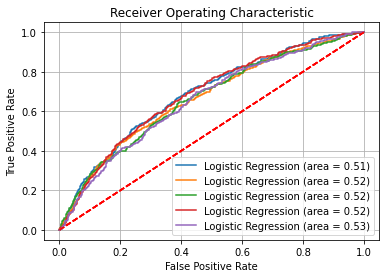

In [56]:
Logistic_Kfold(X=X,y=y,k=5,thrshld=0.5)